## P1 

In [6]:
import numpy as np
def replicas(x, y, L):
    """
    Function to generate replicas of a single particle.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """    
    xr = np.zeros(9)
    yr = np.zeros(9)

    for i in range(3):
        for j in range(3):
            xr[3 * i + j] = x + (j - 1) * L
            yr[3 * i + j] = y + (i - 1) * L
    
    return xr, yr

In [7]:
def pbc(x, y, L):
    """
    Function to enforce periodic boundary conditions on the positions.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """   
    
    outside_left = np.where(x < - L / 2)[0]
    x[outside_left] = x[outside_left] + L

    outside_right = np.where(x > L / 2)[0]
    x[outside_right] = x[outside_right] - L

    outside_up = np.where(y > L / 2)[0]
    y[outside_up] = y[outside_up] - L

    outside_down = np.where(y < - L / 2)[0]
    y[outside_down] = y[outside_down] + L
    
    return x, y

In [8]:
from functools import reduce
import numpy as np

def calculate_intensity(x, y, I0, r0, L, r_c):
    """
    Function to calculate the intensity seen by each particle.
    
    Parameters
    ==========
    x, y : Positions.
    r0 : Standard deviation of the Gaussian light intensity zone.
    I0 : Maximum intensity of the Gaussian.
    L : Dimension of the squared arena.
    r_c : Cut-off radius. Pre-set it around 3 * r0. 
    """
    
    N = np.size(x)

    I_particle = np.zeros(N)  # Intensity seen by each particle.
    
    # Preselect what particles are closer than r_c to the boundaries.
    replicas_needed = reduce( 
        np.union1d, (
            np.where(y + r_c > L / 2)[0], 
            np.where(y - r_c < - L / 2)[0],
            np.where(x + r_c > L / 2)[0],
            np.where(x - r_c > - L / 2)[0]
        )
    )

    for j in range(N - 1):   
        
        # Check if replicas are needed to find the interacting neighbours.
        if np.size(np.where(replicas_needed == j)[0]):
            # Use replicas.
            xr, yr = replicas(x[j], y[j], L)
            for nr in range(9):
                dist2 = (x[j + 1:] - xr[nr]) ** 2 + (y[j + 1:] - yr[nr]) ** 2 
                nn = np.where(dist2 <= r_c ** 2)[0] + j + 1
                
                # The list of nearest neighbours is set.
                # Contains only the particles with index > j
        
                if np.size(nn) > 0:
                    nn = nn.astype(int)
        
                    # Find total intensity
                    dx = x[nn] - xr[nr]
                    dy = y[nn] - yr[nr]
                    d2 = dx ** 2 + dy ** 2
                    I = I0 * np.exp(- d2 / r0 ** 2)
                    
                    # Contribution for particle j.
                    I_particle[j] += np.sum(I)

                    # Contribution for nn of particle j nr replica.
                    I_particle[nn] += I
                
        else:
            dist2 = (x[j + 1:] - x[j]) ** 2 + (y[j + 1:] - y[j]) ** 2 
            nn = np.where(dist2 <= r_c ** 2)[0] + j + 1
        
            # The list of nearest neighbours is set.
            # Contains only the particles with index > j
        
            if np.size(nn) > 0:
                nn = nn.astype(int)
        
                # Find interaction
                dx = x[nn] - x[j]
                dy = y[nn] - y[j]
                d2 = dx ** 2 + dy ** 2
                I = I0 * np.exp(- d2 / r0 ** 2)
                
                # Contribution for particle j.
                I_particle[j] += np.sum(I)

                # Contribution for nn of particle j.
                I_particle[nn] += I
                   
    return I_particle


In [9]:
import numpy as np
N_part = 50  # Number of light-sensitive robots. 
# Note: 5 is enough to demonstrate clustering - dispersal. 

tau = 1  # Timescale of the orientation diffusion.
dt = 0.05  # Time step [s].

v0 = 0.1  # Self-propulsion speed at I=0 [m/s].
v_inf = 0.01  # Self-propulsion speed at I=+infty [m/s].
Ic = 0.1  # Intensity scale where the speed decays.
I0 = 1  # Maximum intensity.
r0 = 0.3  # Standard deviation of the Gaussian light intensity zone [m].


delta = 5 * tau  # Positive delay. More stable clustering.

r_c = 4 * r0  # Cut-off radius [m].
L = 30 * r0  # Side of the arena[m].

# Initialization.

# Random position.
x = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]
y = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]

# Random orientation.
phi = 2 * (np.random.rand(N_part) - 0.5) * np.pi  # in [-pi, pi]

# Coefficients for the finite difference solution.
c_noise_phi = np.sqrt(2 * dt / tau)

# Positive delay.
n_delay = int(delta / dt)  # Delay in units of time steps.
I_memory = np.zeros([n_delay, N_part])
# Initialize.
I_ref = I0 * np.exp(- (x ** 2 + y ** 2) / r0 ** 2)
for i in range(n_delay):
    I_memory[i, :] += I_ref   
    
    

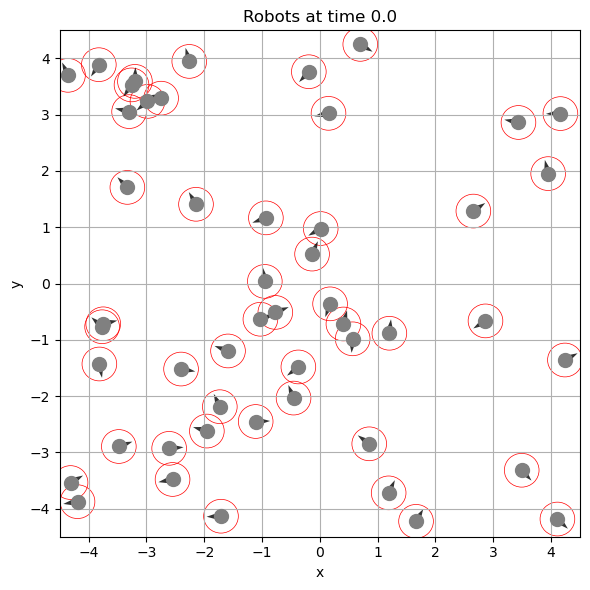

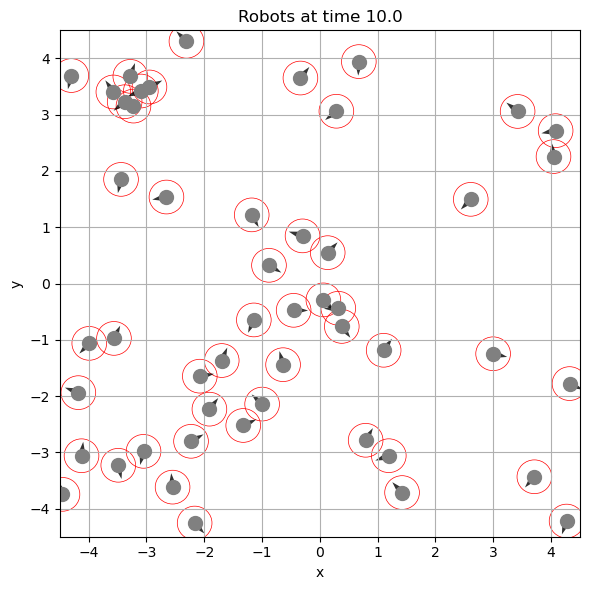

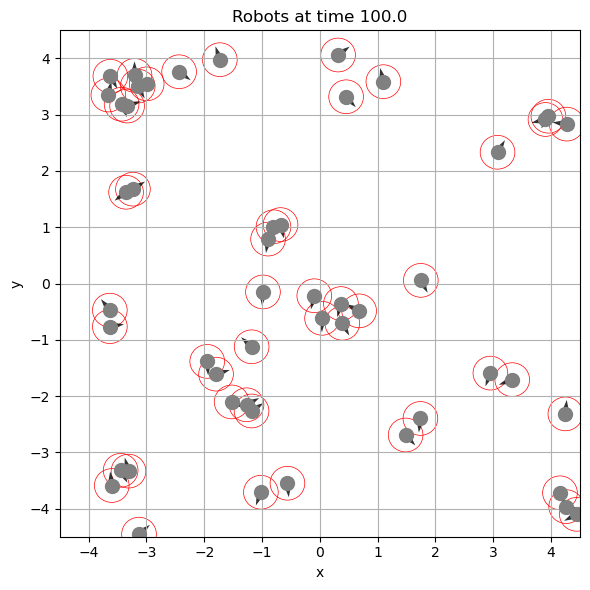

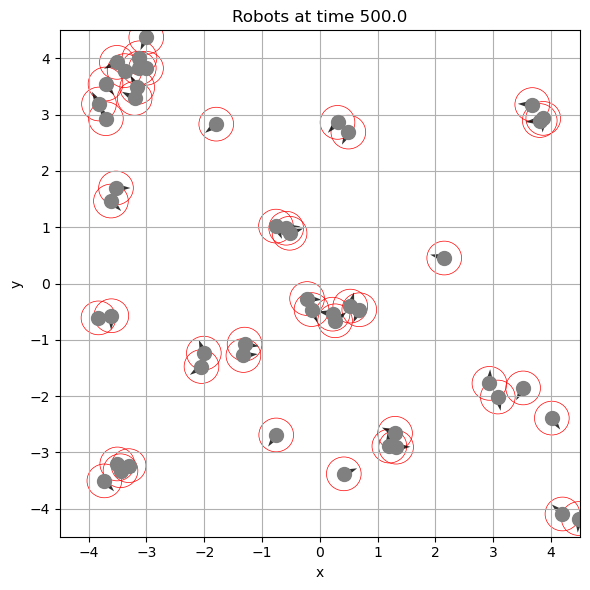

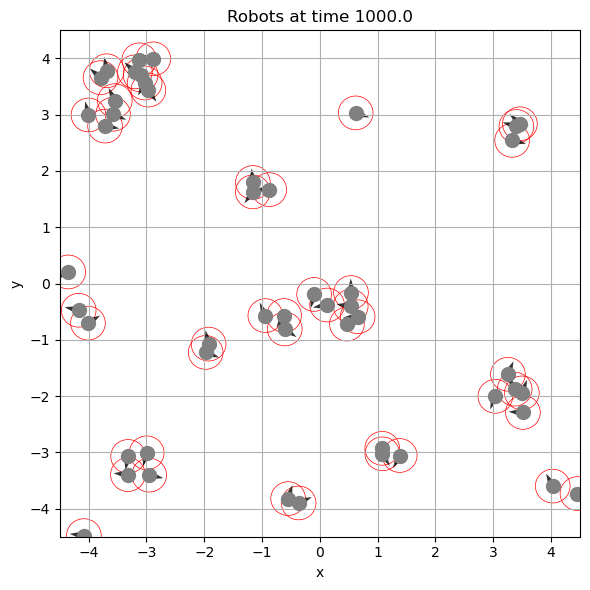

In [10]:
import time
from scipy.constants import Boltzmann as kB 
from tkinter import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


rp = r0 / 3
vp = rp  # Length of the arrow indicating the velocity direction.
line_width = 1  # Width of the arrow line.

step = 0
t_plots = np.array([0,10,100,500,1000])

while step*dt <= t_plots[-1]:
    
    # Calculate current I.
    I_particles = calculate_intensity(x, y, I0, r0, L, r_c)
    
    if delta > 0:
        # Update I_memory.
        I_memory = np.roll(I_memory, -1, axis=0)
        I_memory[-1, :] = I_particles    
        I = I_memory[0, :]
    else:
        I = I_particles
       
    # Calculate new positions and orientations. 
    v = v_inf + (v0 - v_inf) * np.exp(- I / Ic) 
    nx = x + v * dt * np.cos(phi)
    ny = y + v * dt * np.sin(phi)
    nphi = phi + c_noise_phi * np.random.normal(0, 1, N_part)


    # Apply pbc.
    nx, ny = pbc(nx, ny, L)


    if step *dt in t_plots:
            plt.figure(figsize=(6, 6))
            plt.plot(nx, ny, '.', color='gray', markersize=20)
            for x_tmp, y_tmp in zip(nx,ny):
                circle = Circle((x_tmp, y_tmp), r0, color='red', fill=False, linewidth=0.5)
                plt.gca().add_patch(circle)

            plt.quiver(nx, ny, vp*np.cos(nphi), vp*np.sin(nphi), color='black', angles='xy', scale_units='xy', scale=0.4, alpha=0.8)
            plt.title(f'Robots at time {step*dt}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.grid()
            plt.xlim([-L/2,L/2])
            plt.ylim([-L/2,L/2])
            plt.tight_layout()
            plt.show()

    step += 1
    x[:] = nx[:]
    y[:] = ny[:]
    phi[:] = nphi[:]  

## P2

In [ ]:
import numpy as np
N_part = 50  # Number of light-sensitive robots. 
# Note: 5 is enough to demonstrate clustering - dispersal. 

tau = 1  # Timescale of the orientation diffusion.
dt = 0.05  # Time step [s].

v0 = 0.1  # Self-propulsion speed at I=0 [m/s].
v_inf = 0.01  # Self-propulsion speed at I=+infty [m/s].
Ic = 0.1  # Intensity scale where the speed decays.
I0 = 1  # Maximum intensity.
r0 = 0.3  # Standard deviation of the Gaussian light intensity zone [m].

delta = - 5 * tau  # Negative delay. Dispersal.

r_c = 4 * r0  # Cut-off radius [m].
L = 30 * r0  # Side of the arena[m].

# Initialization.

# Random position.
x = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]
y = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]

# Random orientation.
phi = 2 * (np.random.rand(N_part) - 0.5) * np.pi  # in [-pi, pi]

# Coefficients for the finite difference solution.
c_noise_phi = np.sqrt(2 * dt / tau)


# Negative delay.
n_fit = 5 
I_fit = np.zeros([n_fit, N_part])
t_fit = np.arange(n_fit) * dt
dI_dt = np.zeros(N_part)
# Initialize.
I_ref = I0 * np.exp(- (x ** 2 + y ** 2) / r0 ** 2)
for i in range(n_fit):
    I_fit[i, :] += I_ref   
          
        
    

: 

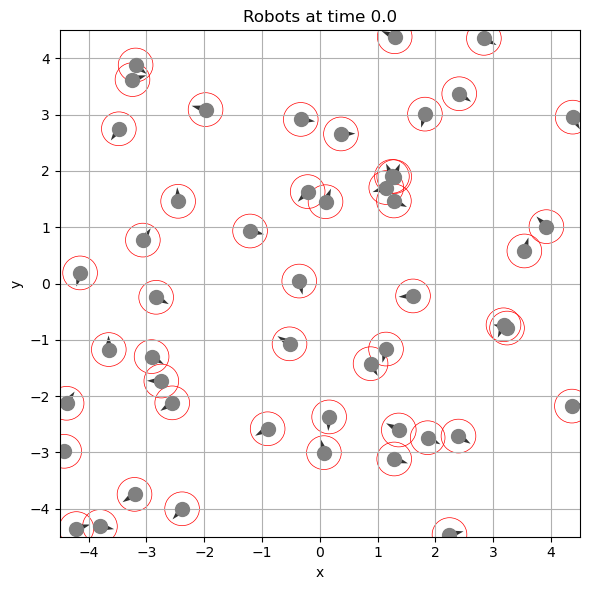

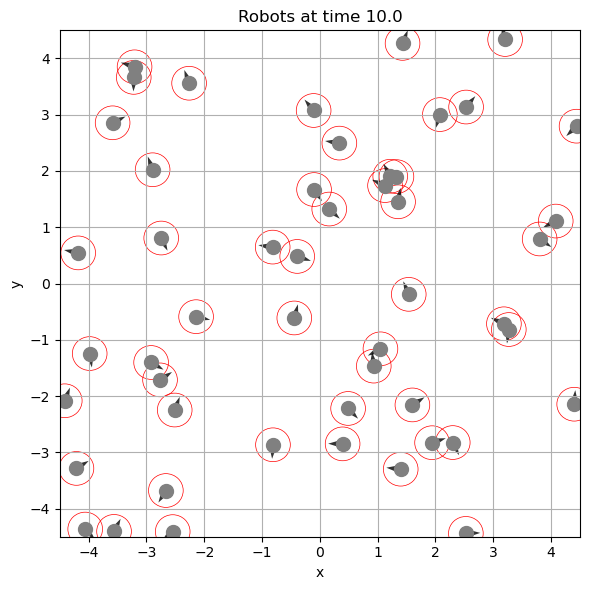

In [ ]:
import time
from scipy.constants import Boltzmann as kB 
from tkinter import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


rp = r0 / 3
vp = rp  # Length of the arrow indicating the velocity direction.
line_width = 1  # Width of the arrow line.

step = 0
t_plots = np.array([0,10,100,500])

while step*dt <= t_plots[-1]:
    
    # Calculate current I.
    I_particles = calculate_intensity(x, y, I0, r0, L, r_c)
    
    if delta < 0:
        # Estimate the derivative of I linear using the last n_fit values.
        for i in range(N_part - 1):
            # Update I_fit.
            I_fit = np.roll(I_fit, -1, axis=0)
            I_fit[-1, :] = I_particles
            # Fit to determine the slope.
            for j in range(N_part):
                p = np.polyfit(t_fit, I_fit[:, j], 1)
                dI_dt[j] = p[0]
            # Determine forecast. Remember that here delta is negative.
            I = I_particles - delta * dI_dt  
            I[np.where(I < 0)[0]] = 0
    else:
        I = I_particles
       
    # Calculate new positions and orientations. 
    v = v_inf + (v0 - v_inf) * np.exp(- I / Ic) 
    nx = x + v * dt * np.cos(phi)
    ny = y + v * dt * np.sin(phi)
    nphi = phi + c_noise_phi * np.random.normal(0, 1, N_part)


    # Apply pbc.
    nx, ny = pbc(nx, ny, L)


    if step *dt in t_plots:
            plt.figure(figsize=(6, 6))
            plt.plot(nx, ny, '.', color='gray', markersize=20)
            for x_tmp, y_tmp in zip(nx,ny):
                circle = Circle((x_tmp, y_tmp), r0, color='red', fill=False, linewidth=0.5)
                plt.gca().add_patch(circle)

            plt.quiver(nx, ny, vp*np.cos(nphi), vp*np.sin(nphi), color='black', angles='xy', scale_units='xy', scale=0.4, alpha=0.8)
            plt.title(f'Robots at time {step*dt}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.grid()
            plt.xlim([-L/2,L/2])
            plt.ylim([-L/2,L/2])
            plt.tight_layout()
            plt.show()

    step += 1
    x[:] = nx[:]
    y[:] = ny[:]
    phi[:] = nphi[:]  